In [1]:
import pandas as pd 
import numpy as np 
from textblob import TextBlob
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import json, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

from sentiment_analysis_spanish import sentiment_analysis
import nltk
import pyLDAvis.gensim_models

import random
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#df = pd.read_excel('Resultados Touchpoint APP Personas del 1abr al 24 May.xlsx')
df = pd.read_excel('Touchpoint APP Personas 1 May al 8 Ago Prepago.xlsx')
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
0,Fecha de inicio,Fecha de finalización,Tipo de respuesta,Dirección IP,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.drop([0], axis=0)
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156000,R_22t2EpjmNZEoqFT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.Q2_NPS_GROUP.value_counts()

Promotor     25789
Detractor     9377
Pasivo        8274
Name: Q2_NPS_GROUP, dtype: int64

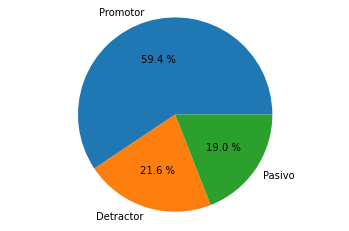

In [5]:
A = df.Q2_NPS_GROUP.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

####  Funciones para Limpieza de texto

In [6]:
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminamos comas y /
    texto = re.sub(r',', ' ', str(texto))
    texto = re.sub(r'/', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [7]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("spanish"))
def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CristhianJohnatanIzq\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stemmer = SnowballStemmer("spanish")
def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

In [9]:
def Limpiar_Caracter(texto):
    if len(texto) == 1 or texto == ',':
        texto = ''
    else:
        texto = texto
    return texto

######  Analisis de sentimientos

In [10]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [11]:
dfSent=df.fillna('')

In [12]:
dfSent["Tokens_Q4"] =  dfSent.Q4.apply(limpiar_texto)
dfSent["Tokens_Q10"] =  dfSent.Q10.apply(limpiar_texto)#'Q10'
dfSent["Tokens_Q12"] =  dfSent.Q12.apply(limpiar_texto)
dfSent["Tokens_Q15"] =  dfSent.Q15.apply(limpiar_texto)
dfSent["Tokens_Q18"] =  dfSent.Q18.apply(limpiar_texto)
dfSent["Tokens_Q20"] =  dfSent.Q20.apply(limpiar_texto)
dfSent.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics,Tokens_Q4,Tokens_Q10,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714,R_3ISGyOV01BzngPO,,...,,,,,,,,,,
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156,R_22t2EpjmNZEoqFT,,...,,,,,,,,,,


In [13]:
dfSent["Sent_Q4"] =  np.where(dfSent["Q4"]!='', dfSent.Q4.apply(sentiment.sentiment)*2-1,'')
dfSent["Sent_Q10"] = np.where(dfSent["Q10"]!='', dfSent.Q10.apply(sentiment.sentiment)*2-1,'') #'Q10'
dfSent["Sent_Q12"] = np.where(dfSent["Q12"]!='', dfSent.Q12.apply(sentiment.sentiment)*2-1,'')
dfSent["Sent_Q15"] = np.where(dfSent["Q15"]!='', dfSent.Q15.apply(sentiment.sentiment)*2-1,'')
dfSent["Sent_Q18"] = np.where(dfSent["Q18"]!='', dfSent.Q18.apply(sentiment.sentiment)*2-1,'')
dfSent["Sent_Q20"] = np.where(dfSent["Q20"]!='', dfSent.Q20.apply(sentiment.sentiment)*2-1,'')

##### Fin Analisis de Sentimiento

####  Preprocesamiento

In [14]:
dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
#dfc = dfc[['Q4','Q10', 'Q12', 'Q15', 'Q18', 'Q20']]
dfc = dfc.fillna('')
dfc.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Sent_Q4,Sent_Q10,Sent_Q12,Sent_Q15,Sent_Q18,Sent_Q20
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,,,,,-0.5171039044034094,,,,,
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,,,,me parece bien,-0.9986340639948205,,,,,-0.8938357315867129


In [15]:
tokenizer = ToktokTokenizer() 
dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(tokenizer.tokenize)
dfc["Tokens_Q10"] = dfc.Tokens_Q10.apply(tokenizer.tokenize) #Q10
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(tokenizer.tokenize)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(tokenizer.tokenize)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(tokenizer.tokenize)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(tokenizer.tokenize)
dfc.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Sent_Q4,Sent_Q10,Sent_Q12,Sent_Q15,Sent_Q18,Sent_Q20
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,[],[],[],[],-0.5171039044034094,,,,,
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,[],[],[],"[me, parece, bien]",-0.9986340639948205,,,,,-0.8938357315867129
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,[],"[mala, señal]",[],[],,,,-0.9673870115141259,,
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,[],"[me, cambié, un, mes, otro, operador, me, regr...",[],[],-0.9780022650589095,,,-0.9543426980470776,,
13,2021-05-01 01:31:59,2021-05-01 01:35:12,IP Address,191.156.2.216,100,193,True,2021-05-01 01:35:12.335,R_1laRSYqAGwFA04C,,...,[],"[se, demora, para, cargar, después, dice, lo, ...",[nada],[],,,,-0.999999852091098,-0.5979510811689109,


In [16]:
dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(filtrar_stopword_digitos)
dfc["Tokens_Q10"] = dfc.Tokens_Q10.apply(filtrar_stopword_digitos)#Q10
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(filtrar_stopword_digitos)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(filtrar_stopword_digitos)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(filtrar_stopword_digitos)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(filtrar_stopword_digitos)
dfc.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Sent_Q4,Sent_Q10,Sent_Q12,Sent_Q15,Sent_Q18,Sent_Q20
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,[],[],[],[],-0.5171039044034094,,,,,
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,[],[],[],"[parece, bien]",-0.9986340639948205,,,,,-0.8938357315867129


In [17]:
dfc["Tokens_Q4"] = dfc.Tokens_Q4.apply(stem_palabras)
dfc["Tokens_Q10"] = dfc.Tokens_Q10.apply(stem_palabras) #Q10
dfc["Tokens_Q12"] = dfc.Tokens_Q12.apply(stem_palabras)
dfc["Tokens_Q15"] = dfc.Tokens_Q15.apply(stem_palabras)
dfc["Tokens_Q18"] = dfc.Tokens_Q18.apply(stem_palabras)
dfc["Tokens_Q20"] = dfc.Tokens_Q20.apply(stem_palabras)
dfc.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q12,Tokens_Q15,Tokens_Q18,Tokens_Q20,Sent_Q4,Sent_Q10,Sent_Q12,Sent_Q15,Sent_Q18,Sent_Q20
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,[],[],[],[],-0.5171039044034094,,,,,
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,[],[],[],"[parec, bien]",-0.9986340639948205,,,,,-0.8938357315867129
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,[],"[mal, señal]",[],[],,,,-0.9673870115141259,,
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],-0.9780022650589095,,,-0.9543426980470776,,
13,2021-05-01 01:31:59,2021-05-01 01:35:12,IP Address,191.156.2.216,100,193,True,2021-05-01 01:35:12.335,R_1laRSYqAGwFA04C,,...,[],"[demor, carg, despues, dic, sient, trabaj, ser...",[],[],,,,-0.999999852091098,-0.5979510811689109,


###  Modelo de Tópicos

In [18]:
### Funciones para modelo de tópicos
def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,bigram_mod,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [37]:
list_Q4 = dfc["Tokens_Q4"].tolist()
list_Q10 = dfc["Tokens_Q10"].tolist() 
list_Q12 = dfc["Tokens_Q12"].tolist()
list_Q15 = dfc["Tokens_Q15"].tolist()
list_Q18 = dfc["Tokens_Q18"].tolist()
list_Q20 = dfc["Tokens_Q20"].tolist()

list_Q4 = [x for x in list_Q4 if x!= []]
list_Q10 = [x for x in list_Q10 if x!= []]
list_Q12 = [x for x in list_Q12 if x!= []]
list_Q15 = [x for x in list_Q15 if x!= []]
list_Q18 = [x for x in list_Q18 if x!= []]
list_Q20 = [x for x in list_Q20 if x!= []]

print("tamaño Q4 ", len(list_Q4))
print("tamaño Q10 ", len(list_Q10))
print("tamaño Q12", len(list_Q12))
print("tamaño Q15", len(list_Q15))
print("tamaño Q18", len(list_Q18))
print("tamaño Q20", len(list_Q20))

Lista_general = list_Q4+list_Q10+list_Q12+list_Q15+list_Q18 #Q10

bigram = gensim.models.Phrases(Lista_general, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[Lista_general], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_bigrams = make_bigrams(Lista_general,bigram_mod)

diccionario = Dictionary(data_words_bigrams)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=2, no_above = 0.9)
print(f'Número de tokens: {len(diccionario)}')

corpus = [diccionario.doc2bow(noticia) for noticia in data_words_bigrams]

tamaño Q4  3345
tamaño Q10  853
tamaño Q12 2251
tamaño Q15 5928
tamaño Q18 4924
tamaño Q20 1366
Número de tokens: 4786
Número de tokens: 2246


In [20]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=5, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [21]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(0, '0.081*"dat" + 0.074*"internet" + 0.071*"mal" + 0.055*"lent" + 0.046*"señal"')
(1, '0.105*"pag" + 0.079*"factur" + 0.050*"pud" + 0.050*"hac" + 0.043*"recarg"')
(2, '0.056*"pued" + 0.043*"ver" + 0.043*"plan" + 0.032*"clar" + 0.029*"consult"')
(3, '0.091*"dej" + 0.075*"app" + 0.062*"ingres" + 0.052*"registr" + 0.040*"aplic"')
(4, '0.155*"servici" + 0.066*"funcion" + 0.037*"pesim" + 0.037*"carg" + 0.025*"tecnic"')


In [22]:
#Impresion limpia de Tópicos
topicos = lda.print_topics(num_words=15, num_topics=20)
i=0
for topico in topicos:
    i=i+1
    textoAux = re.sub(r'\W', ' ', str(topico))
    textoAux = re.sub(r'\s+[a-zA-Z]\s+', ' ', textoAux)
    textoAux = re.sub(r'[0-9]', ' ', textoAux)
    textoAux = re.sub(r'\s+', ' ', textoAux, flags=re.I)
    print(str(i),textoAux)

1  dat internet mal lent señal sirv asesor respond mejor cae chat abrir referent red habl_asesor 
2  pag factur pud hac recarg aparec pod celul realiz sald compr quier cancel mir encontr 
3  pued ver plan clar consult cuent equip clar_hog hog inform opcion si necesit cambi movil 
4  dej app ingres registr aplic numer dic line permit llam eleg entrar actualiz famili_amig telefon 
5  servici funcion pesim carg tecnic client fall demor vec contest contact dan buen proces bloque 


In [23]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [24]:
pyLDAvis.save_html(lda_display, 'lda_General_4_V3.html')

####  fin simplificación

###  Clasificación de los textos en tópicos

In [25]:
dfc2 = df[df['Q2_NPS_GROUP']!='Promotor']
dfc2 = dfc.fillna('')

In [26]:
dfc2["Tokens_Q4_T"] =  dfc2["Tokens_Q4"]
dfc2["Tokens_Q10_T"] =  dfc2["Tokens_Q10"]
dfc2["Tokens_Q12_T"] =  dfc2["Tokens_Q12"]
dfc2["Tokens_Q15_T"] =  dfc2["Tokens_Q15"]
dfc2["Tokens_Q18_T"] =  dfc2["Tokens_Q18"]
dfc2["Tokens_Q20_T"] =  dfc2["Tokens_Q20"]

dfc2["Tokens_Q4"] =  dfc2.Q4.apply(limpiar_texto)
dfc2["Tokens_Q10"] =  dfc2.Q10.apply(limpiar_texto) 
dfc2["Tokens_Q12"] =  dfc2.Q12.apply(limpiar_texto)
dfc2["Tokens_Q15"] =  dfc2.Q15.apply(limpiar_texto)
dfc2["Tokens_Q18"] =  dfc2.Q18.apply(limpiar_texto)
dfc2["Tokens_Q20"] =  dfc2.Q20.apply(limpiar_texto)

dfc2["Tokens_Q4"] =  dfc2.Q4.apply(Limpiar_Caracter)
dfc2["Tokens_Q10"] =  dfc2.Q10.apply(Limpiar_Caracter)
dfc2["Tokens_Q12"] =  dfc2.Q12.apply(Limpiar_Caracter)
dfc2["Tokens_Q15"] =  dfc2.Q15.apply(Limpiar_Caracter)
dfc2["Tokens_Q18"] =  dfc2.Q18.apply(Limpiar_Caracter)
dfc2["Tokens_Q20"] =  dfc2.Q20.apply(Limpiar_Caracter)

dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q12,Sent_Q15,Sent_Q18,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,,,,,[ningun],[],[],[],[],[]
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,,,,-0.8938357315867129,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],[],"[parec, bien]"


In [27]:
dfc2['Opinion'] = ''
for i in dfc2.index:
    #dfc2.loc[i,'Opinion'] =str(dfc2.loc[i,'Tokens_Q4'])+" "+str(dfc2.loc[i,'Tokens_Q10'])+" "+str(dfc2.loc[i,'Tokens_Q12']) + " " + str(dfc2.loc[i,'Tokens_Q15']) + " " + str(dfc2.loc[i,'Tokens_Q18']) 
    dfc2.loc[i,'Opinion'] =str(dfc2.loc[i,'Tokens_Q12']) + " " + str(dfc2.loc[i,'Tokens_Q15']) + " " + str(dfc2.loc[i,'Tokens_Q18']) 
dfc2

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q15,Sent_Q18,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,,,,[ningun],[],[],[],[],[],
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,,,-0.8938357315867129,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],[],"[parec, bien]",
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,-0.9673870115141259,,,[],[],[],"[mal, señal]",[],[],Mala señal
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,-0.9543426980470776,,,"[bastant, tiemp, usted, sub, plan, line]",[],[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],Me cambié x un mes a otro operador y me regre...
13,2021-05-01 01:31:59,2021-05-01 01:35:12,IP Address,191.156.2.216,100,193,True,2021-05-01 01:35:12.335,R_1laRSYqAGwFA04C,,...,-0.999999852091098,-0.5979510811689109,,[],[],[],"[demor, carg, despues, dic, sient, trabaj, ser...",[],[],Se demora para cargar y después dice lo sient...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2021-08-08 23:06:19,2021-08-08 23:08:27,IP Address,186.84.91.69,100,127,True,2021-08-08 23:08:27.483,R_3qlYjnE8E36TyLC,,...,-0.9999999982663534,-0.9999996312900163,,[],[],"[mas, facil, encontr, hac, cos]","[pued, pag, factur, tampoc, pued, ver, consum,...","[pud, ver, consum, dat, tampoc, pag, factur]",[],Antes era mas facil encontrar y hacer las cosa...
48048,2021-08-08 23:39:41,2021-08-08 23:40:38,IP Address,181.51.32.254,100,56,True,2021-08-08 23:40:38.430,R_sToi9iywAO42BRn,,...,,,,[],[],[],[],[],[],
48049,2021-08-08 23:40:25,2021-08-08 23:43:02,IP Address,181.78.12.127,100,157,True,2021-08-08 23:43:03.328,R_3kugDTodOoTWqZe,,...,,,,[],[],[],[],[],[],
48050,2021-08-08 23:40:35,2021-08-08 23:43:18,IP Address,191.102.221.222,100,163,True,2021-08-08 23:43:19.277,R_2YRIKXkrkI4ZEKr,,...,-0.004215481588850323,-0.8937365993784213,,[],[],[],[bn],"[entend, bien, graci]",[],Bn No lo entendí bien gracias 😊


In [28]:
dfc2['Opinion'] = dfc2['Opinion'].apply(tokenizer.tokenize)
dfc2['Opinion'] = dfc2['Opinion'].apply(filtrar_stopword_digitos)
dfc2['Opinion'] = dfc2['Opinion'].apply(stem_palabras)
dfc2['Opinion'] 

4                                                       []
9                                                       []
10                                            [mal, señal]
11       [me, cambi, x, mes, oper, regres, nuev, sub, m...
13       [se, demor, carg, despues, dic, sient, trabaj,...
                               ...                        
48043    [antes, mas, facil, encontr, hac, cos, ya, pue...
48048                                                   []
48049                                                   []
48050                     [bn, no, entend, bien, graci, 😊]
48052            [es, lent, app, se, demor, entrar, aplic]
Name: Opinion, Length: 22263, dtype: object

In [29]:
for i in dfc2.index:    
    if dfc2.loc[i,'Opinion']==[]:
        dfc2.drop([i], inplace=True)
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q15,Sent_Q18,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,-0.9673870115141259,,,[],[],[],"[mal, señal]",[],[],"[mal, señal]"
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,-0.9543426980470776,,,"[bastant, tiemp, usted, sub, plan, line]",[],[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],"[me, cambi, x, mes, oper, regres, nuev, sub, m..."


In [30]:
dfc2['Tópico'] = ""
sumaTopicos = [0,0,0,0,0,0]
for i in dfc2.index:
    try:
        
        bow_comentario = diccionario.doc2bow(dfc2.loc[i,'Opinion'])
        distribucion_noticia = lda[bow_comentario]
        dist_contrib = [topico[1] for topico in lda[bow_comentario]]
        if (dist_contrib[0] > dist_contrib[1]) & (dist_contrib[0] > dist_contrib[2]) & (dist_contrib[0] > dist_contrib[3]) & (dist_contrib[0] > dist_contrib[4]):
            dfc2.loc[i,'Tópico'] = 1
        elif (dist_contrib[1] > dist_contrib[0]) & (dist_contrib[1] > dist_contrib[2]) & (dist_contrib[1] > dist_contrib[3]) & (dist_contrib[1] > dist_contrib[4]):
            dfc2.loc[i,'Tópico'] = 2
        elif (dist_contrib[2] > dist_contrib[0]) & (dist_contrib[2] > dist_contrib[1]) & (dist_contrib[2] > dist_contrib[3]) & (dist_contrib[2] > dist_contrib[4]):
            dfc2.loc[i,'Tópico'] = 3
        elif (dist_contrib[3] > dist_contrib[0]) & (dist_contrib[3] > dist_contrib[1]) & (dist_contrib[3] > dist_contrib[2]) & (dist_contrib[3] > dist_contrib[4]):
            dfc2.loc[i,'Tópico'] = 4
        elif (dist_contrib[4] > dist_contrib[0]) & (dist_contrib[4] > dist_contrib[1]) & (dist_contrib[4] > dist_contrib[2]) & (dist_contrib[4] > dist_contrib[3]):
            dfc2.loc[i,'Tópico'] = 5
        # sumar pertenencias a los tópicos
        sumaTopicos[1]=sumaTopicos[1]+ dist_contrib[0] 
        sumaTopicos[2]=sumaTopicos[2]+ dist_contrib[1] 
        sumaTopicos[3]=sumaTopicos[3]+ dist_contrib[2] 
        sumaTopicos[4]=sumaTopicos[4]+ dist_contrib[3] 
        sumaTopicos[5]=sumaTopicos[5]+ dist_contrib[4]         
    except:
        print('No')

In [31]:
dfc2.Tópico.value_counts()

3    4273
2    1481
4     762
1     428
5     187
Name: Tópico, dtype: int64

#####  Validación asignación de Tópicos

In [32]:
for index,score in sorted(lda[diccionario.doc2bow(dfc2.loc[i,'Opinion'])], key=lambda tup: -1*tup[1]):
    print("Score:{}\t Topic:{}".format(score,lda.print_topic(index,5)))

Score:0.32115861773490906	 Topic:0.091*"dej" + 0.075*"app" + 0.062*"ingres" + 0.052*"registr" + 0.040*"aplic"
Score:0.2543855309486389	 Topic:0.056*"pued" + 0.043*"ver" + 0.043*"plan" + 0.032*"clar" + 0.029*"consult"
Score:0.14808495342731476	 Topic:0.081*"dat" + 0.074*"internet" + 0.071*"mal" + 0.055*"lent" + 0.046*"señal"
Score:0.13874313235282898	 Topic:0.105*"pag" + 0.079*"factur" + 0.050*"pud" + 0.050*"hac" + 0.043*"recarg"
Score:0.1376277655363083	 Topic:0.155*"servici" + 0.066*"funcion" + 0.037*"pesim" + 0.037*"carg" + 0.025*"tecnic"


####  fin validacion

###  zoom al topico_5  número 3

In [92]:
## Quitar pag pactur
dfc2_5_3=dfc2.copy()
dfc2_5_3['contienePagFact']=dfc2_5_3['Opinion'].apply(lambda x: 1 if 'pag' in x else 0)

In [94]:
dfc2_5_3=dfc2_5_3[dfc2_5_3['contienePagFact']==0]
dfc2_5_3=dfc2_5_3[dfc2_5_3['Tópico']==3]

In [95]:
list_Q4_5_3 = dfc2_5_3["Tokens_Q4_T"].tolist()
list_Q10_5_3 = dfc2_5_3["Tokens_Q10_T"].tolist() 
list_Q12_5_3 = dfc2_5_3["Tokens_Q12_T"].tolist()
list_Q15_5_3 = dfc2_5_3["Tokens_Q15_T"].tolist()
list_Q18_5_3 = dfc2_5_3["Tokens_Q18_T"].tolist()
list_Q20_5_3 = dfc2_5_3["Tokens_Q20_T"].tolist()

list_Q4_5_3 = [x for x in list_Q4_5_3 if x!= []]
list_Q10_5_3 = [x for x in list_Q10_5_3 if x!= []] 
list_Q12_5_3 = [x for x in list_Q12_5_3 if x!= []]
list_Q15_5_3 = [x for x in list_Q15_5_3 if x!= []]
list_Q18_5_3 = [x for x in list_Q18_5_3 if x!= []]
list_Q20_5_3 = [x for x in list_Q20_5_3 if x!= []]

In [96]:
Lista_general_5_3 = list_Q4_5_3+list_Q10_5_3+list_Q12_5_3+list_Q15_5_3+list_Q18_5_3 
bigram_5_3 = gensim.models.Phrases(Lista_general_5_3, min_count=5, threshold=10) 
trigram_5_3 = gensim.models.Phrases(bigram_5_3[Lista_general_5_3], threshold=10)
bigram_mod_5_3 = gensim.models.phrases.Phraser(bigram_5_3)
trigram_mod_5_3 = gensim.models.phrases.Phraser(trigram_5_3)
data_words_bigrams_5_3 = make_bigrams(Lista_general_5_3,bigram_mod_5_3)
diccionario_5_3 = Dictionary(data_words_bigrams_5_3)
diccionario_5_3.filter_extremes(no_below=2, no_above = 0.9)
corpus_5_3 = [diccionario_5_3.doc2bow(noticia) for noticia in data_words_bigrams_5_3]

In [97]:
lda_5_3 = LdaModel(corpus=corpus_5_3, id2word=diccionario_5_3, 
               num_topics=5, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [98]:
lda_display = pyLDAvis.gensim_models.prepare(lda_5_3, corpus_5_3, diccionario_5_3, sort_topics=False)
pyLDAvis.display(lda_display)

In [99]:
# asignacion topicos
dfc2_5_3['Tópico_5_3_5'] = ""
for i in dfc2_5_3.index:
    try:
        
        bow_comentario = diccionario_5_3.doc2bow(dfc2_5_3.loc[i,'Opinion'])
        distribucion_noticia = lda_5_3[bow_comentario]

        dist_contrib = [topico[1] for topico in lda_5_3[bow_comentario]]

        if (dist_contrib[0] > dist_contrib[1]) & (dist_contrib[0] > dist_contrib[2]) & (dist_contrib[0] > dist_contrib[3]) & (dist_contrib[0] > dist_contrib[4]):
            dfc2_5_3.loc[i,'Tópico_5_3_5'] = 1
        elif (dist_contrib[1] > dist_contrib[0]) & (dist_contrib[1] > dist_contrib[2]) & (dist_contrib[1] > dist_contrib[3]) & (dist_contrib[1] > dist_contrib[4]):
            dfc2_5_3.loc[i,'Tópico_5_3_5'] = 2
        elif (dist_contrib[2] > dist_contrib[0]) & (dist_contrib[2] > dist_contrib[1]) & (dist_contrib[2] > dist_contrib[3]) & (dist_contrib[2] > dist_contrib[4]):
            dfc2_5_3.loc[i,'Tópico_5_3_5'] = 3
        elif (dist_contrib[3] > dist_contrib[0]) & (dist_contrib[3] > dist_contrib[1]) & (dist_contrib[3] > dist_contrib[2]) & (dist_contrib[3] > dist_contrib[4]):
            dfc2_5_3.loc[i,'Tópico_5_3_5'] = 4
        elif (dist_contrib[4] > dist_contrib[0]) & (dist_contrib[4] > dist_contrib[1]) & (dist_contrib[4] > dist_contrib[2]) & (dist_contrib[4] > dist_contrib[3]):
            dfc2_5_3.loc[i,'Tópico_5_3_5'] = 5
    except:
        print('No',str(i))

In [100]:
dfc2_5_3.Tópico_5_3_5.value_counts()

3    2236
1    1117
2     424
5     128
4      54
Name: Tópico_5_3_5, dtype: int64

######  fin Zoom

####  Construcción Tabla Final 

In [102]:
TablaFinal=df.copy()
TablaFinal['Sent_Q4']=dfSent["Sent_Q4"] 
TablaFinal['Sent_Q10']=dfSent["Sent_Q10"]
TablaFinal['Sent_Q12']=dfSent["Sent_Q12"] 
TablaFinal['Sent_Q15']=dfSent["Sent_Q15"] 
TablaFinal['Sent_Q18']=dfSent["Sent_Q18"] 
TablaFinal['Sent_Q20']=dfSent["Sent_Q20"]
TablaFinal['Opinion']=dfc2['Opinion']
TablaFinal['Topico']=dfc2['Tópico']
TablaFinal['Tópico_5_3_5']=dfc2_5_3['Tópico_5_3_5']

In [102]:
TablaFinal.to_csv('TablaFinalV2.csv', index=False, sep=';')